# MLServer - Retrieve and Classify

This notebook retrieves data from an Azure Function server, performs classification using a machine learning model and uploads the results back to the cloud.

All of that is performed using API REST endpoints exposed in Azure.

Segmentation model is DeepLabV3+, at https://github.com/bonlime/keras-deeplab-v3-plus

## Retrieving and Visualizing Next Task

In [1]:
import requests
import base64
from PIL import Image
import io

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

getnexttask_url = 'https://blobstorefuncteste.azurewebsites.net/api/getnexttask_v0?code=YCbRpKphpfyJR5Sa4oELsAaV4Zz6Pt8EdtasFt10zazr6ae3mQZapA=='
puttaskresult_url = 'https://blobstorefuncteste.azurewebsites.net/api/puttaskresult_v0?code=skiy0tiMnOol4m/MgPBvCtTZIHri6DFB3wW8491dhFmyIYybABaCSw=='

In [2]:
def get_next_task(url):
    r = requests.post(url, data={})
    split_data = r.text.split('|')
    return { 'task_id' : split_data[0], 'payload' : base64.b64decode(split_data[1]) }

next_task = get_next_task(getnexttask_url)
next_task['task_id']

'59729da0-affb-45ec-b867-c9544f935946.payload'

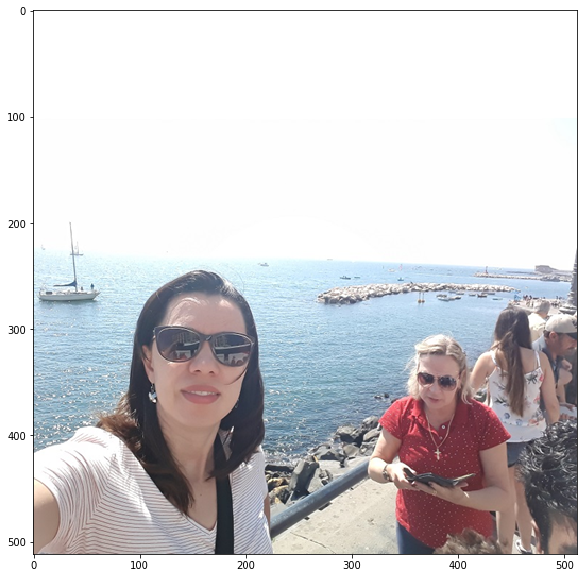

In [3]:
image_data = next_task['payload']
image = np.asarray(Image.open(io.BytesIO(image_data)))
plt.figure(figsize=(10,10))
plt.imshow(image)

## Compute Predictions

In [4]:
from matplotlib import pyplot as plt
import cv2 # used for resize. if you dont have it, use anything else
from deepLab import Deeplabv3
deeplab_model = Deeplabv3(backbone='xception')

label_names = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

Using TensorFlow backend.


In [5]:
img = image
w, h, _ = img.shape
ratio = 512. / np.max([w,h])
resized = cv2.resize(img,(int(ratio*h),int(ratio*w)))[:,:,0:3]

pad_x = int(512 - resized.shape[0])
pad_y = int(512 - resized.shape[1])
resized2 = np.pad(resized,((0,pad_x),(0,pad_y),(0,0)),mode='constant')

img_resized = resized2
resized2 = resized2 / 127.5 - 1.

1/1 [==============================] - 3s 3s/step


(-0.5, 511.5, 511.5, -0.5)

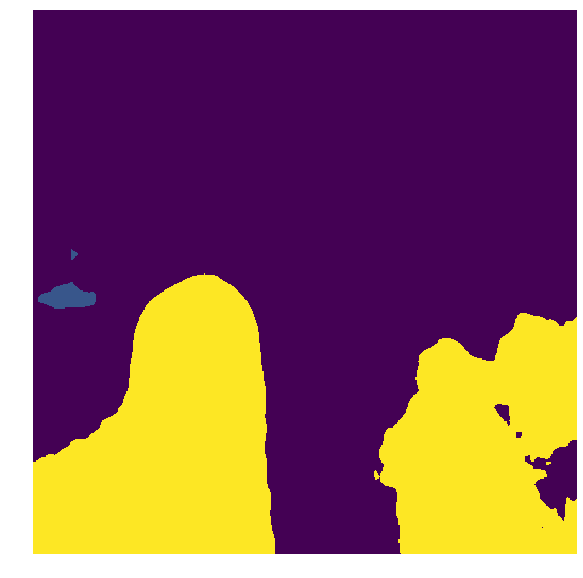

In [6]:
res = deeplab_model.predict(np.expand_dims(resized2,0), verbose=1)
labels = np.argmax(res.squeeze(),-1)
plt.figure(figsize=(10,10))
plt.imshow(labels)
plt.axis('off')
#plt.savefig('mask.png')

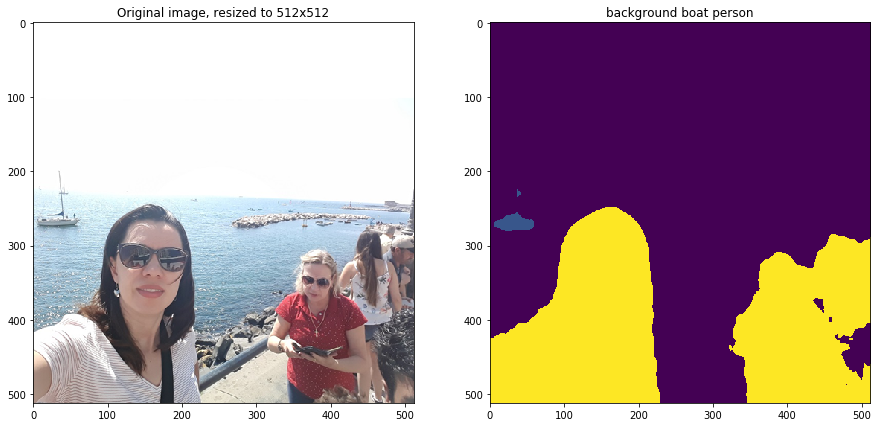

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title('Original image, resized to 512x512')
plt.imshow(img_resized)
plt.subplot(1,2,2)
cur_labels = ' '.join(label_names[np.unique(labels)])
plt.title(cur_labels)
plt.imshow(labels)

In [8]:
np.unique(labels)

array([ 0,  4, 15], dtype=int64)

In [9]:
import imageio
imageio.imwrite('mask.png', labels.astype(np.uint8))

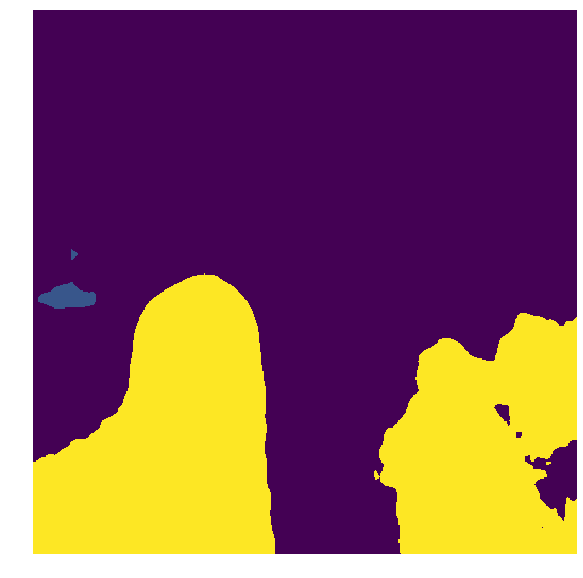

In [10]:
with open('mask.png', "rb") as image_file:
    encoded_string = base64.b64encode(image_file.read())
    #encoded_string = base64.urlsafe_b64encode(image_file.read())
    
    
encimg=base64.b64decode(encoded_string)
#encimg=base64.urlsafe_b64decode(encoded_string)


image_data = encimg
image = np.asarray(Image.open(io.BytesIO(image_data)))
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image)

## Send Predictions to Server

In [11]:
type(encoded_string)

bytes

In [12]:
def send_task_result(url, task_id, result_b64):
    x = result_b64.decode("utf8")
    r = requests.post(url, json={'task_id':task_id, 'result':x})
    return r
ans = send_task_result(puttaskresult_url, next_task['task_id'], encoded_string)

In [13]:
ans

<Response [200]>